In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
% matplotlib inline

In [3]:
# Create generators for training, validation and testing
# Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
# Image resizing is done by the generator so a folder with any sized-images can be used
# The named directory must contain one or more subfolders, path should look like apples_train/apple_class1/img1.jpg...

batch_size = 85
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    'apples_train/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    'apples_test/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = test_datagen.flow_from_directory(
    'eggplant/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

Found 6416 images belonging to 13 classes.
Found 2138 images belonging to 13 classes.
Found 468 images belonging to 3 classes.


In [ ]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(4,4), padding='same')) # using pool_size (4,4) makes the layer 4x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(4,4), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------
model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(16,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()

# Compile the model
model.compile(optimizer='adadelta', loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 3)           219       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 3)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 3)           84        
__________

In [ ]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = 'models/model1.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
model.fit_generator(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        epochs=600,
        validation_data=validation_generator,
        validation_steps=1000 // batch_size,
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/600
11/11 [==============================] - 23s 2s/step - loss: 0.1202 - val_loss: 0.1196
Epoch 2/600
11/11 [==============================] - 15s 1s/step - loss: 0.1158 - val_loss: 0.1134
Epoch 3/600
11/11 [==============================] - 16s 1s/step - loss: 0.1109 - val_loss: 0.1080
Epoch 4/600
11/11 [==============================] - 16s 1s/step - loss: 0.1050 - val_loss: 0.1014
Epoch 5/600
11/11 [==============================] - 6213s 565s/step - loss: 0.0967 - val_loss: 0.0927
Epoch 6/600
11/11 [==============================] - 24s 2s/step - loss: 0.0908 - val_loss: 0.0853
Epoch 7/600
11/11 [==============================] - 21s 2s/step - loss: 0.0868 - val_loss: 0.0828
Epoch 8/600
11/11 [==============================] - 18s 2s/step - loss: 0.0830 - val_loss: 0.0813
Epoch 9/600
11/11 [==============================] - 17s 2s/step - loss: 0.0788 - val_loss: 0.0761
Epoch 10/600
11/11 [==============================] - 18s 2s/step - loss: 0.0736 - val_loss: 0.0824
Epoch

Epoch 83/600
11/11 [==============================] - 15s 1s/step - loss: 0.0298 - val_loss: 0.0306
Epoch 84/600
11/11 [==============================] - 16s 1s/step - loss: 0.0306 - val_loss: 0.0309
Epoch 85/600
11/11 [==============================] - 15s 1s/step - loss: 0.0305 - val_loss: 0.0309
Epoch 86/600
11/11 [==============================] - 15s 1s/step - loss: 0.0293 - val_loss: 0.0301
Epoch 87/600
11/11 [==============================] - 15s 1s/step - loss: 0.0291 - val_loss: 0.0328
Epoch 88/600
11/11 [==============================] - 15s 1s/step - loss: 0.0300 - val_loss: 0.0294
Epoch 89/600
11/11 [==============================] - 15s 1s/step - loss: 0.0286 - val_loss: 0.0313
Epoch 90/600
11/11 [==============================] - 14s 1s/step - loss: 0.0298 - val_loss: 0.0308
Epoch 91/600
11/11 [==============================] - 15s 1s/step - loss: 0.0298 - val_loss: 0.0314
Epoch 92/600
11/11 [==============================] - 15s 1s/step - loss: 0.0295 - val_loss: 0.0308


11/11 [==============================] - 15s 1s/step - loss: 0.0245 - val_loss: 0.0245
Epoch 246/600
11/11 [==============================] - 15s 1s/step - loss: 0.0236 - val_loss: 0.0254
Epoch 247/600
11/11 [==============================] - 15s 1s/step - loss: 0.0241 - val_loss: 0.0234
Epoch 248/600
11/11 [==============================] - 14s 1s/step - loss: 0.0235 - val_loss: 0.0258
Epoch 249/600
11/11 [==============================] - 15s 1s/step - loss: 0.0235 - val_loss: 0.0246
Epoch 250/600
11/11 [==============================] - 15s 1s/step - loss: 0.0234 - val_loss: 0.0245
Epoch 251/600
11/11 [==============================] - 15s 1s/step - loss: 0.0234 - val_loss: 0.0268
Epoch 252/600
11/11 [==============================] - 17s 2s/step - loss: 0.0238 - val_loss: 0.0234
Epoch 253/600
11/11 [==============================] - 16s 1s/step - loss: 0.0240 - val_loss: 0.0247
Epoch 254/600
11/11 [==============================] - 16s 1s/step - loss: 0.0232 - val_loss: 0.0240
Epoc

11/11 [==============================] - 27s 2s/step - loss: 0.0218 - val_loss: 0.0211
Epoch 408/600
11/11 [==============================] - 31s 3s/step - loss: 0.0214 - val_loss: 0.0224
Epoch 409/600
11/11 [==============================] - 30s 3s/step - loss: 0.0209 - val_loss: 0.0218
Epoch 410/600
11/11 [==============================] - 34s 3s/step - loss: 0.0226 - val_loss: 0.0226
Epoch 411/600
11/11 [==============================] - 34s 3s/step - loss: 0.0217 - val_loss: 0.0222
Epoch 412/600
11/11 [==============================] - 35s 3s/step - loss: 0.0217 - val_loss: 0.0226
Epoch 413/600
11/11 [==============================] - 32s 3s/step - loss: 0.0211 - val_loss: 0.0215
Epoch 414/600
11/11 [==============================] - 35s 3s/step - loss: 0.0212 - val_loss: 0.0209
Epoch 415/600
11/11 [==============================] - 37s 3s/step - loss: 0.0205 - val_loss: 0.0243
Epoch 416/600
11/11 [==============================] - 33s 3s/step - loss: 0.0222 - val_loss: 0.0226
Epoc

In [15]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

In [18]:
model_filepath

'models/model1.keras'

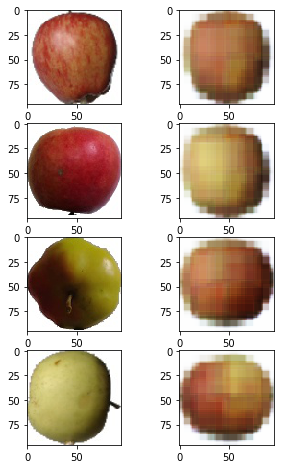

In [17]:
# Test the model by viewing a sample of original and reconstructed images
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [19]:
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate_generator(validation_generator)}, error on anomaly set:{model.evaluate_generator(anomaly_generator)}")

Error on validation set:0.02017475672020909, error on anomaly set:0.07263157970439164


# Extracting the encoded image

In [20]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3), weights=model.layers[0].get_weights()) )
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(8,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 6, 3)           219       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 3)           0         
Total params: 1,827
Trainable params: 1,827
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
encoded_images = encoder_replica.predict_generator(train_generator)
encoded_images_flat = [np.reshape(img, (27)) for img in encoded_images]

validation_encoded = encoder_replica.predict_generator(validation_generator)
val_enc_flat = [np.reshape(img, (27)) for img in validation_encoded]

anom_encoded = encoder_replica.predict_generator(anomaly_generator)
anom_enc_flat = [np.reshape(img, (27)) for img in anom_encoded]

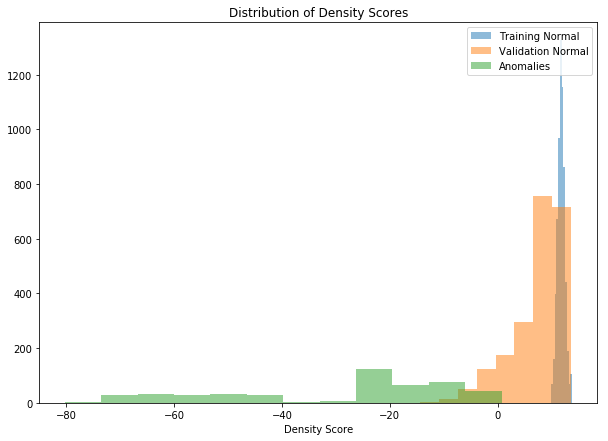

In [22]:
# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)
anomaly_density_scores = kde.score_samples(anom_enc_flat)

# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [23]:
# Creat a function that will classify whether an unseen image is normal or an anomaly
# Low density and high reconstruction error mean that the image is likely to be anomalous
def check_anomaly(img_path):
    density_threshold = 0 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.04 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    img  = Image.open(img_path)
    img = np.array(img.resize((96,96), Image.ANTIALIAS))
    img = img / 255
    encoded_img = encoder_replica.predict([[img]]) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (27)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
#     print(f'density: {density}')
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)
#     print(f'reconstruction_error: {reconstruction_error}')
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return True
    else:
        return False

In [24]:
# Check what proportion of onion images are classified as anomalous
onion_files = []
for (dirpath, dirnames, filenames) in os.walk('onions'):
    for x in filenames:
        if x.endswith(".jpg"):
            onion_files.append(os.path.join(dirpath, x))

onion_predictions = []
for file in onion_files:
    onion_predictions.append(check_anomaly(file))
print(sum(onion_predictions)/len(onion_predictions))

1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step
0.9667405764966741


In [25]:
# Check what proportion of apples are classified as anomalous (we hope that this will be close to zero)
apples_test = []
for (dirpath, dirnames, filenames) in os.walk('apples_test'):
    for x in filenames:
        if x.endswith(".jpg"):
            apples_test.append(os.path.join(dirpath, x))

apples_predictions = []
for file in apples_test:
    apples_predictions.append(check_anomaly(file))
print(sum(apples_predictions)/len(apples_predictions))

1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step
0.1627689429373246


In [26]:
# Check what proportion of aubergines/eggplants get classed as anomalous.
eggplant_test = []
for (dirpath, dirnames, filenames) in os.walk('eggplant'):
    for x in filenames:
        if x.endswith(".jpg"):
            eggplant_test.append(os.path.join(dirpath, x))

eggplant_predictions = []
for file in eggplant_test:
    eggplant_predictions.append(check_anomaly(file))
print(sum(eggplant_predictions)/len(eggplant_predictions))

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 5ms/step
0.967948717948718


In [27]:
peppers_test = []
for (dirpath, dirnames, filenames) in os.walk('peppers'):
    for x in filenames:
        if x.endswith(".jpg"):
            peppers_test.append(os.path.join(dirpath, x))

peppers_predictions = []
for file in peppers_test:
    peppers_predictions.append(check_anomaly(file))
print(sum(peppers_predictions)/len(peppers_predictions))

1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 6ms/step
1.0


In [31]:
len(peppers_predictions)

592